In [2]:
from zipfile import ZipFile
file_name = 'drive/MyDrive/SDP_Datasets/maize-leaf-data.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [5]:
train_path = 'maize-leaf/train'
valid_path = 'maize-leaf/test'

In [6]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# IMAGE_SIZE + [3] - RGB images
# include_top = False removes last layer of VGG16 since VGG16 classifies 1000 category of images

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
# Model is already trained, don't train existing weights again
for layer in vgg.layers:
    layer.trainable = False

In [8]:
# useful for getting number of classes of dataset
folders = glob('maize-leaf/train/*')

In [9]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x) # our layers - you can add more if you want
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('maize-leaf/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('maize-leaf/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3768 images belonging to 4 classes.
Found 414 images belonging to 4 classes.


In [14]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs = 30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
118/118 [==============================] - 54s 391ms/step - loss: 0.7319 - accuracy: 0.7285 - val_loss: 0.3905 - val_accuracy: 0.8671
Epoch 2/30
118/118 [==============================] - 44s 370ms/step - loss: 0.2777 - accuracy: 0.9001 - val_loss: 0.2387 - val_accuracy: 0.9130
Epoch 3/30
118/118 [==============================] - 44s 370ms/step - loss: 0.2180 - accuracy: 0.9189 - val_loss: 0.3228 - val_accuracy: 0.8720
Epoch 4/30
118/118 [==============================] - 44s 371ms/step - loss: 0.2025 - accuracy: 0.9311 - val_loss: 0.2412 - val_accuracy: 0.9203
Epoch 5/30
118/118 [==============================] - 44s 372ms/step - loss: 0.1783 - accuracy: 0.9330 - val_loss: 0.2432 - val_accuracy: 0.9130
Epoch 6/30
118/118 [==============================] - 44s 370ms/step - loss: 0.1243 - accuracy: 0.9558 - val_loss: 0.2389 - val_accuracy: 0.9251
Epoch 7/30
118/118 [==============================] - 44s 374ms/step - loss: 0.1233 - accuracy: 0.9573 - val_loss: 0.7484 - val_ac

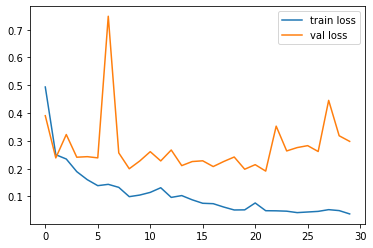

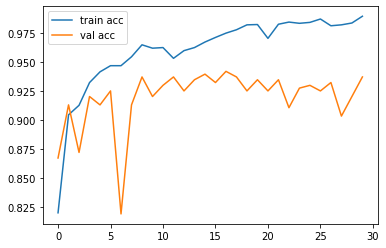

<Figure size 432x288 with 0 Axes>

In [16]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
from keras.models import load_model
model.save('maize-leaf-model.h5')